In [1]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as LGB
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')


mpl.rc("figure", figsize=(100, 70))
mpl.rcParams.update({'font.size':25})

pd.set_option('display.max_columns', 500)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Loading data

In [2]:
merged_data = pd.read_csv("../data/train/merged_data_after_feature_engineering.csv")

## Separating the train test features

In [3]:
train = merged_data[merged_data.is_test ==0]
test = merged_data[merged_data.is_test ==1]

train['redemption_status'] =train['redemption_status'].astype('int64')
train.shape

(78369, 72)

In [4]:
columns_with_other_dtype = merged_data.select_dtypes(include=['object', 'datetime64[ns]']).columns
columns_with_numeric_dtype = merged_data.select_dtypes(exclude='object').columns
columns_with_numeric_dtype



Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'customer_age_range',
       'customer_marital_status', 'is_customer_rented', 'customer_family_size',
       'customer_no_of_children', 'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discount_on_brand2', 'no_of_times_customer_bought_category1',
       'no_of_times_customer_bough

In [5]:
categorical_columns = columns_with_other_dtype.drop(labels=['campaign_start_date', 'campaign_end_date', 'coupon_available_on_item_ids'])
numerical_columns = columns_with_numeric_dtype.drop(labels=['coupon_id', 'customer_id', 'id'])
features = numerical_columns.append(categorical_columns)
features

Index(['campaign_id', 'is_test', 'redemption_status', 'campaign_type',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discount_on_brand2', 'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_

In [6]:
features = features.drop(labels=['is_test', 'redemption_status'])
features.shape

(64,)

## Defining a method for parameter comparision

In [7]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

## Creating a Stratified k-fold split

In [8]:
X = train[features]
Y = train['redemption_status']

skf = StratifiedKFold(n_splits=3)

## Tuning an intuition based model

In [13]:
%%time

param_grid = {
    'n_estimators': [1500],
    'learning_rate': [0.2],
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.5108853295505071, total= 1.4min
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.611631087985998, total= 1.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min


[CV]  learning_rate=0.2, n_estimators=1500, score=0.4997746007212777, total= 1.6min
[CV]  learning_rate=0.2, n_estimators=1500, score=0.5616155021407381, total=  50.2s
[CV]  learning_rate=0.2, n_estimators=1500, score=0.9519326113498903, total= 2.6min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


CPU times: user 47.8 s, sys: 2.3 s, total: 50.1 s
Wall time: 3min 20s


In [14]:
roc_auc_score(clf.predict(X), Y.values)

0.6030807650700853

In [15]:
sum(clf.predict(test[features]))

757

best parameters: {'learning_rate': 0.2, 'n_estimators': 1500}
best score:      0.62717 (+/-0.16719)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,94.068645,33.183867,1.391622,0.707054,0.2,1500,"{'learning_rate': 0.2, 'n_estimators': 1500}",0.951933,0.510885,0.611631,0.499775,0.561616,0.627169,0.16719,1,1.0,0.519544,0.628857,0.499783,0.572608,0.644158,0.183494


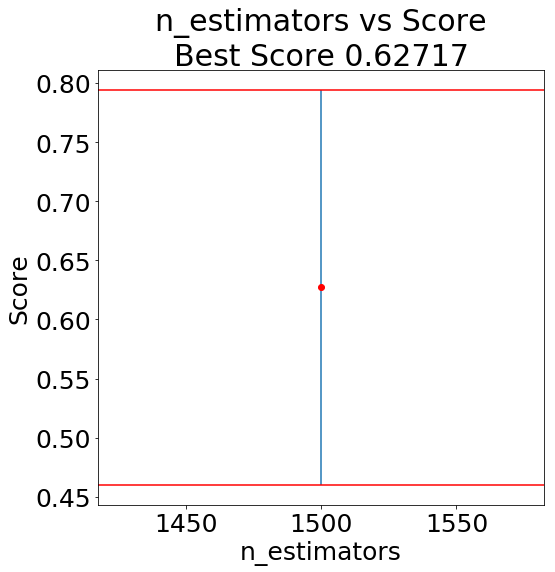

In [16]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

## Tuning an in_estimators

In [19]:
%%time

param_grid = {
    'n_estimators': [1500, 2000, 2500],
    'learning_rate': [0.2, 0.3],
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.5684587453155766, total= 1.3min
[CV] learning_rate=0.2, n_estimators=1500 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.5575242337306713, total= 1.4min
[CV] learning_rate=0.2, n_estimators=2000 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.49993560020607936, total= 1.5min
[CV] learning_rate=0.2, n_estimators=2000 ............................
[CV]  learning_rate=0.2, n_estimators=1500, score=0.6128384320204658, total= 1.8min
[CV] learning_rate=0.2, n_estimators=2000 ............................
[CV]  learning_rate=0.2, n_estimato

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.6min finished


CPU times: user 1min 4s, sys: 2.97 s, total: 1min 7s
Wall time: 17min 30s


In [20]:
roc_auc_score(clf.predict(X), Y.values)

0.5448845397399456

In [21]:
sum(clf.predict(test[features]))

1035

best parameters: {'learning_rate': 0.2, 'n_estimators': 2500}
best score:      0.65478 (+/-0.15128)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,176.981642,119.031789,3.272543,3.795279,0.2,2500,"{'learning_rate': 0.2, 'n_estimators': 2500}",0.950934,0.583587,0.529112,0.626596,0.583642,0.654775,0.151277,1,1.000000,0.612066,0.536488,0.664804,0.594549,0.681581,0.164396
0,122.051566,69.108722,2.124884,1.740660,0.2,1500,"{'learning_rate': 0.2, 'n_estimators': 1500}",0.951933,0.568459,0.557524,0.499936,0.612838,0.638138,0.160974,2,1.000000,0.588286,0.546895,0.504135,0.616325,0.651128,0.178518
1,158.735848,89.690508,2.866700,2.987477,0.2,2000,"{'learning_rate': 0.2, 'n_estimators': 2000}",0.951203,0.551704,0.602259,0.505530,0.548627,0.631866,0.162585,3,1.000000,0.589614,0.640162,0.520168,0.535233,0.657036,0.176648
3,80.359564,8.422225,0.683148,0.122861,0.3,1500,"{'learning_rate': 0.3, 'n_estimators': 1500}",0.505974,0.588918,0.626362,0.534365,0.609864,0.573096,0.045706,4,0.513071,0.584142,0.611172,0.551265,0.624014,0.576733,0.040442
5,96.453136,7.228726,0.681996,0.189949,0.3,2500,"{'learning_rate': 0.3, 'n_estimators': 2500}",0.555235,0.538931,0.632774,0.499678,0.582034,0.561730,0.044434,5,0.576297,0.532066,0.616604,0.509152,0.593112,0.565446,0.039455
4,95.628063,10.077484,0.682231,0.180670,0.3,2000,"{'learning_rate': 0.3, 'n_estimators': 2000}",0.617961,0.519042,0.511447,0.522462,0.544792,0.543141,0.039022,6,0.639381,0.531312,0.511833,0.527270,0.560062,0.553972,0.045462


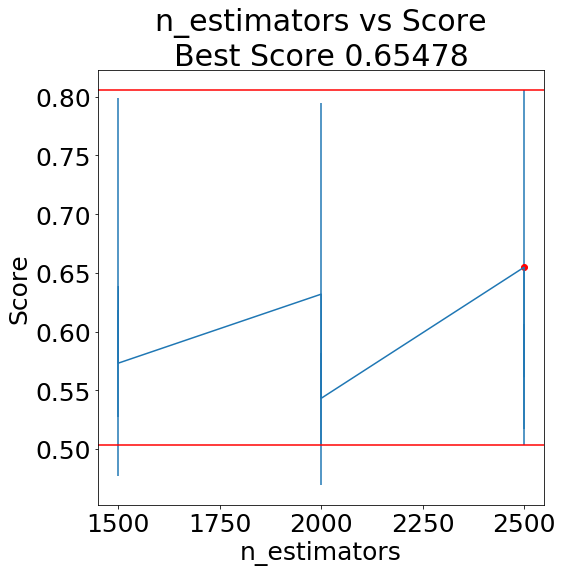

In [22]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

## Moving ahead with n_estimators = 2000 and learning_rate =0.2

### Tuning max_depth

In [25]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.2],
    'max_depth': np.arange(3, 25, 5)
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] learning_rate=0.2, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.2, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.2, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.2, max_depth=3, n_estimators=2000 ...............
[CV]  learning_rate=0.2, max_depth=3, n_estimators=2000, score=0.9770529419237365, total= 2.8min
[CV] learning_rate=0.2, max_depth=3, n_estimators=2000 ...............
[CV]  learning_rate=0.2, max_depth=3, n_estimators=2000, score=0.9666625203785649, total= 2.9min
[CV] learning_rate=0.2, max_depth=8, n_estimators=2000 ...............
[CV]  learning_rate=0.2, max_depth=3, n_estimators=2000, score=0.9689791485817929, total= 2.9min
[CV] learning_rate=0.2, max_depth=8, n_estimators=2000 ...............
[CV]  learning_rate=0.2, max_depth=3, n_estimators=2000, score=0.9671697790293098, total= 2.9min
[CV] learning_rate=0.2, max_depth=8, n_estimators=2000 

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 26.9min finished


CPU times: user 1min 7s, sys: 3.66 s, total: 1min 10s
Wall time: 30min 12s


In [26]:
roc_auc_score(clf.predict(X), Y.values)

0.9999549242082759

In [27]:
sum(clf.predict(test[features]))

19

best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 2000}
best score:      0.96914 (+/-0.00408)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,159.831967,14.660464,5.071562,1.287536,0.2,3,2000,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.967170,0.968979,0.966663,0.977053,0.965859,0.969145,0.004085,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.219355e-08
1,327.494967,33.242555,12.918314,2.416612,0.2,8,2000,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.946629,0.965156,0.962024,0.962070,0.959588,0.959093,0.006478,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.219355e-08
2,184.036656,96.913452,3.763664,3.599735,0.2,13,2000,"{'learning_rate': 0.2, 'max_depth': 13, 'n_est...",0.607492,0.963466,0.582985,0.534542,0.539145,0.645527,0.161294,3,0.631433,1.000000,0.600591,0.555290,0.540754,0.665613,1.702772e-01
4,196.411339,104.308046,2.999639,2.901384,0.2,23,2000,"{'learning_rate': 0.2, 'max_depth': 23, 'n_est...",0.951162,0.538063,0.551495,0.566139,0.586397,0.638652,0.157078,4,1.000000,0.548510,0.563109,0.559775,0.619768,0.658232,1.726648e-01
3,210.958394,136.164610,3.676935,3.984995,0.2,18,2000,"{'learning_rate': 0.2, 'max_depth': 18, 'n_est...",0.963421,0.536131,0.537912,0.542770,0.495202,0.615089,0.175003,5,1.000000,0.564492,0.541636,0.543837,0.506028,0.631198,1.853566e-01


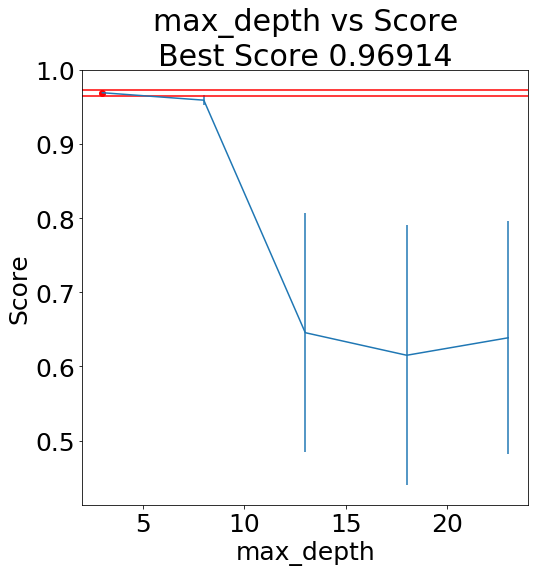

In [30]:
GridSearch_table_plot(clf, "max_depth", display_all_params=False, negative=False)

Taking max_depth=3 and max_depth=13

### Tuning min_data_in_leaf

In [42]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5, 10]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000, score=0.5198408707557889, total=  39.1s
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000, score=0.9624284544755211, total= 1.7min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=2000, score=0.9568916160290203, total= 1.7min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=2000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=2000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.9min remaining:  2.1min


[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=2000, score=0.9609507879711772, total= 1.8min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=2000, score=0.9693911308250938, total= 1.8min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=2000, score=0.9598620512000569, total= 1.5min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.3min finished


CPU times: user 1min 22s, sys: 2.18 s, total: 1min 24s
Wall time: 5min 43s


In [43]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [44]:
sum(clf.predict(test[features]))

91

best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 10, 'n_estimators': 2000}
best score:      0.88847 (+/-0.14657)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,82.656894,21.251763,7.668170,5.120949,0.2,5,10,2000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.956682,0.969391,0.960951,0.595450,0.959862,0.888466,0.146570,1,1.0,1.0,1.0,0.633624,1.0,0.926725,0.146551
0,85.180376,24.846747,7.301648,3.731637,0.2,5,5,2000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.962428,0.956892,0.958719,0.519841,0.946052,0.868785,0.174559,2,1.0,1.0,1.0,0.520854,1.0,0.904171,0.191659


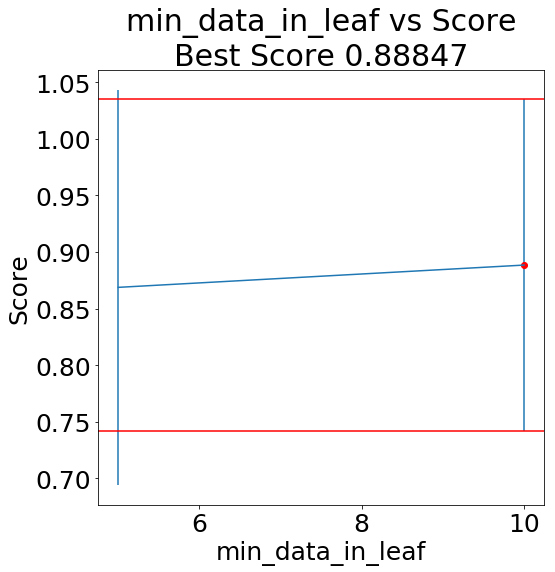

In [45]:
GridSearch_table_plot(clf, "min_data_in_leaf", display_all_params=False, negative=False)

## Tuning n_estimators again

In [54]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [10]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.5633336685651373, total= 2.3min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9543921541642847, total= 6.4min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.1min remaining: 12.2min


[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9594572420655925, total= 6.5min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9688768146626863, total= 6.6min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9598016486347243, total= 9.8min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


CPU times: user 2min 25s, sys: 6.55 s, total: 2min 31s
Wall time: 22min 20s


In [59]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [60]:
sum(clf.predict(test[features]))

91

In [ ]:
GridSearch_table_plot(clf, "min_data_in_leaf", display_all_params=False, negative=False)

## Tuning n_estimators again

In [54]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [10]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.5633336685651373, total= 2.3min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9543921541642847, total= 6.4min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.1min remaining: 12.2min


[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9594572420655925, total= 6.5min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9688768146626863, total= 6.6min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000, score=0.9598016486347243, total= 9.8min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


CPU times: user 2min 25s, sys: 6.55 s, total: 2min 31s
Wall time: 22min 20s


In [59]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [60]:
sum(clf.predict(test[features]))

91

In [ ]:
GridSearch_table_plot(clf, "min_data_in_leaf", display_all_params=False, negative=False)

## Tuning max_depth again

In [64]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [3, 5,8,10],
    'min_data_in_leaf' : [10]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000, score=0.5275796528410014, total= 2.1min
[CV] learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000, score=0.9630812743043058, total= 3.9min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=3, min_data_in_leaf=10, n_estimators=4000, score=0.97432344928825, total= 3.9min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=10, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=3, min_data_in

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 21.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 21.3min finished


CPU times: user 2min 27s, sys: 6.62 s, total: 2min 34s
Wall time: 26min 18s


In [65]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [66]:
sum(clf.predict(test[features]))

91

best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 10, 'n_estimators': 4000}
best score:      0.89276 (+/-0.13582)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,303.826088,97.953012,15.750126,7.313671,0.2,5,10,4000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.954392,0.968877,0.959457,0.621291,0.959802,0.892763,0.135817,1,1.000000,1.000000,1.000000,0.655692,1.000000,0.931138,0.137723
0,204.941775,41.069136,10.111540,4.412701,0.2,3,10,4000,"{'learning_rate': 0.2, 'max_depth': 3, 'min_da...",0.527580,0.967520,0.963081,0.974323,0.964943,0.879488,0.175997,2,0.538158,1.000000,1.000000,1.000000,1.000000,0.907632,0.184737
2,158.488494,8.790763,1.521818,0.144869,0.2,8,10,4000,"{'learning_rate': 0.2, 'max_depth': 8, 'min_da...",0.592505,0.614582,0.509016,0.620226,0.582385,0.583743,0.039862,3,0.590931,0.681578,0.529765,0.625390,0.594842,0.604501,0.049478
3,180.304682,4.328620,1.359341,0.105523,0.2,10,10,4000,"{'learning_rate': 0.2, 'max_depth': 10, 'min_d...",0.541727,0.509400,0.557220,0.524701,0.519299,0.530469,0.016996,4,0.542731,0.546858,0.616662,0.545449,0.532925,0.556925,0.030262


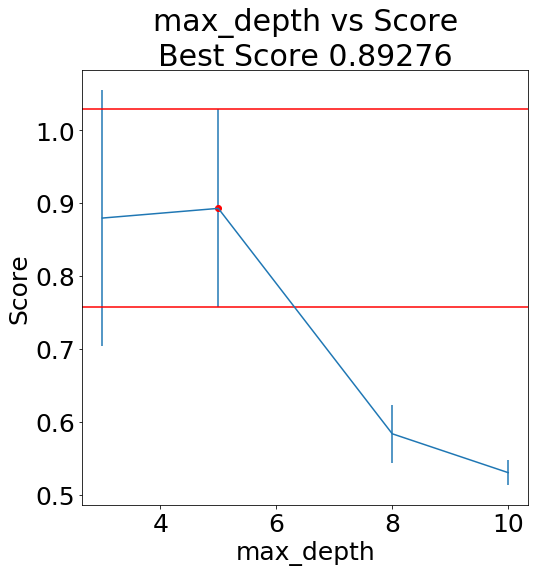

In [67]:
GridSearch_table_plot(clf, "max_depth", display_all_params=False, negative=False)

## Tuning min_data_in_leaf again

In [69]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [3,5,9,12]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000, score=0.9561319734641047, total= 5.4min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000, score=0.9613194166173731, total= 5.5min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=3, n_estimators=4000, score=0.9466442937012232, total= 5.6min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=9, n_estimators=4000 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=5,

[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 18.0min remaining:  3.6min


[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=12, n_estimators=4000, score=0.9617805509442122, total= 4.0min
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=12, n_estimators=4000, score=0.9618932903365325, total= 3.9min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.1min finished


CPU times: user 2min 28s, sys: 6.66 s, total: 2min 34s
Wall time: 19min 46s


In [70]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [71]:
sum(clf.predict(test[features]))

95

best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 9, 'n_estimators': 4000}
best score:      0.95856 (+/-0.00482)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,236.995754,21.600242,33.856424,3.998043,0.2,5,9,4000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.952815,0.958263,0.964614,0.958564,0.004822,1,1.000000,1.0,1.0,1.000000,1.218082e-07
1,275.666583,19.628129,37.635914,2.039496,0.2,5,5,4000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.952806,0.960731,0.961543,0.958360,0.003941,2,1.000000,1.0,1.0,1.000000,1.218082e-07
0,292.068881,2.711518,38.584011,1.904415,0.2,5,3,4000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.946644,0.956132,0.961319,0.954699,0.006076,3,1.000000,1.0,1.0,1.000000,1.218082e-07
3,167.021932,56.420813,20.992817,13.226255,0.2,5,12,4000,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.607602,0.961781,0.961893,0.843759,0.166988,4,0.622257,1.0,1.0,0.874086,1.780697e-01


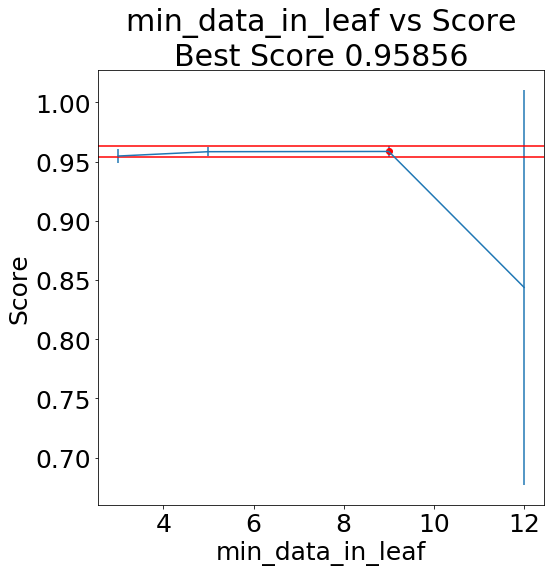

In [72]:
GridSearch_table_plot(clf, "min_data_in_leaf", display_all_params=False, negative=False)

We'll use 7

## Tuning num_leaves

In [77]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [7],
    'num_leaves': [20,25,30,35,50]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20 
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=25 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20, score=0.5585289178926479, total= 2.0min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=25 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20, score=0.9611529312242004, total= 5.3min
[CV] learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=25 
[CV]  learning_rate=0.2, max_depth=5, min_data_in_leaf=7, n_estimators=4000, num_leaves=20, score=0.9568501504251976, total= 5.4mi

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 24.3min finished


CPU times: user 2min 24s, sys: 5.66 s, total: 2min 29s
Wall time: 27min 46s


In [78]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [79]:
sum(clf.predict(test[features]))

87

best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 7, 'n_estimators': 4000, 'num_leaves': 35}
best score:      0.95962 (+/-0.00511)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,285.195935,6.313952,33.867665,1.030133,0.2,5,7,4000,35,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.952457,0.962402,0.964015,0.959625,0.005111,1,1.0,1.000000,1.0,1.000000,1.218082e-07
4,250.311245,40.148184,25.238773,0.108104,0.2,5,7,4000,50,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.952457,0.962402,0.964015,0.959625,0.005111,2,1.0,1.000000,1.0,1.000000,1.218082e-07
2,297.785905,22.142985,31.753456,4.329445,0.2,5,7,4000,30,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.955244,0.961579,0.961908,0.959577,0.003067,3,1.0,1.000000,1.0,1.000000,1.218082e-07
1,301.556607,24.060850,29.040369,5.042886,0.2,5,7,4000,25,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.953198,0.955650,0.963944,0.957597,0.004598,4,1.0,1.000000,1.0,1.000000,1.218082e-07
0,231.742478,80.071068,22.245226,13.832027,0.2,5,7,4000,20,"{'learning_rate': 0.2, 'max_depth': 5, 'min_da...",0.956850,0.558529,0.961153,0.825511,0.188793,5,1.0,0.577422,1.0,0.859141,1.992048e-01


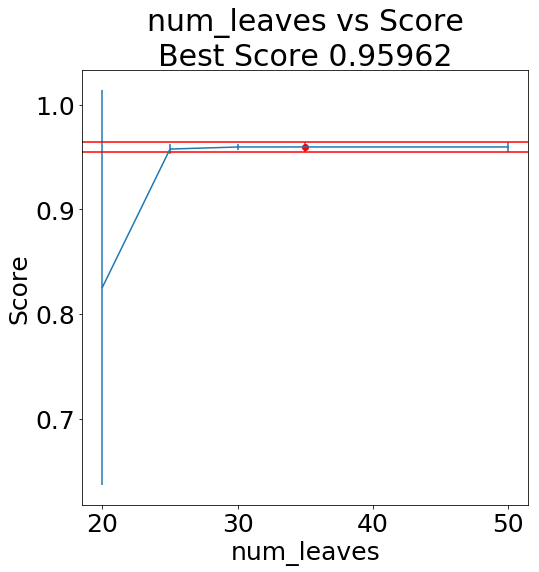

In [ ]:
GridSearch_table_plot(clf, "num_leaves", display_all_params=False, negative=False)

## Tuning subsampling parameters

In [9]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5],
    'num_leaves': [30],
    'feature_fraction': [0.2, 0.3, 0.5, 0.6]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] feature_fraction=0.2, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV] feature_fraction=0.2, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV] feature_fraction=0.2, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV] feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV]  feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9586021428435134, total= 3.9min
[CV] feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV]  feature_fraction=0.2, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9590042837788845, total= 4.3min
[CV] feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data

[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 16.8min remaining:  3.4min


[CV]  feature_fraction=0.6, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9393006500403891, total= 5.1min
[CV]  feature_fraction=0.6, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9581410880225925, total= 5.0min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 17.3min finished


CPU times: user 1min 29s, sys: 5.22 s, total: 1min 34s
Wall time: 21min 10s


In [10]:
roc_auc_score(clf.predict(X), Y.values)

0.9999678021765729

In [11]:
sum(clf.predict(test[features]))

93

best parameters: {'feature_fraction': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 4000, 'num_leaves': 30}
best score:      0.96316 (+/-0.00323)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_fraction,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,197.953738,5.506980,34.688225,4.066585,0.3,0.2,5,5,4000,30,"{'feature_fraction': 0.3, 'learning_rate': 0.2...",0.958602,0.965072,0.965791,0.963155,0.003233,1,1.0,1.000000,1.0,1.000000,1.218082e-07
0,212.666805,1.880592,47.874891,0.832488,0.2,0.2,5,5,4000,30,"{'feature_fraction': 0.2, 'learning_rate': 0.2...",0.959004,0.962969,0.965992,0.962655,0.002861,2,1.0,1.000000,1.0,1.000000,1.218082e-07
2,222.519763,29.972009,36.524879,7.891289,0.5,0.2,5,5,4000,30,"{'feature_fraction': 0.5, 'learning_rate': 0.2...",0.958875,0.964392,0.963406,0.962225,0.002402,3,1.0,1.000000,1.0,1.000000,1.218082e-07
3,201.043557,92.937595,26.312590,17.371180,0.6,0.2,5,5,4000,30,"{'feature_fraction': 0.6, 'learning_rate': 0.2...",0.939301,0.510864,0.958141,0.802769,0.206551,4,1.0,0.524199,1.0,0.841399,2.242948e-01


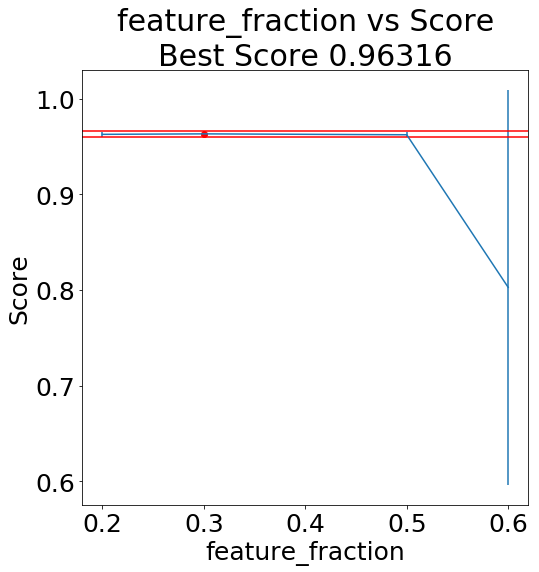

In [12]:
GridSearch_table_plot(clf, "feature_fraction", display_all_params=False, negative=False)

Using 0.5

### Tuning max_bin

In [17]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5],
    'num_leaves': [9],
    'feature_fraction': [0.5],
    'max_bin': [150,200, 300]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] feature_fraction=0.5, learning_rate=0.2, max_bin=150, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] feature_fraction=0.5, learning_rate=0.2, max_bin=150, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] feature_fraction=0.5, learning_rate=0.2, max_bin=150, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] feature_fraction=0.5, learning_rate=0.2, max_bin=200, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV]  feature_fraction=0.5, learning_rate=0.2, max_bin=200, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.5414970010367571, total= 2.6min
[CV] feature_fraction=0.5, learning_rate=0.2, max_bin=200, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV]  feature_fraction=0.5, learning_rate=0.2, max_bin=150, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.6531143263304521

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  6.7min remaining:  3.4min


[CV]  feature_fraction=0.5, learning_rate=0.2, max_bin=200, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.9639260976587097, total= 4.5min
[CV]  feature_fraction=0.5, learning_rate=0.2, max_bin=300, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.9513251251423156, total= 4.5min
[CV]  feature_fraction=0.5, learning_rate=0.2, max_bin=300, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.5584816913771062, total= 1.9min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.1min finished


CPU times: user 50.4 s, sys: 2.19 s, total: 52.6 s
Wall time: 9min 35s


In [20]:
roc_auc_score(clf.predict(X), Y.values)

0.5854811623283793

In [21]:
sum(clf.predict(test[features]))

623

best parameters: {'feature_fraction': 0.5, 'learning_rate': 0.2, 'max_bin': 150, 'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 4000, 'num_leaves': 9}
best score:      0.76353 (+/-0.13192)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_fraction,param_learning_rate,param_max_bin,param_max_depth,param_min_data_in_leaf,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,208.720135,72.558524,8.941173,6.913611,0.5,0.2,150,5,5,4000,9,"{'feature_fraction': 0.5, 'learning_rate': 0.2...",0.948964,0.653114,0.688503,0.763527,0.131917,1,1.000000,0.684545,0.742750,0.809098,0.137063
1,170.422286,60.430176,8.517102,8.384428,0.5,0.2,200,5,5,4000,9,"{'feature_fraction': 0.5, 'learning_rate': 0.2...",0.541497,0.963926,0.640085,0.715169,0.180444,2,0.538659,1.000000,0.679142,0.739267,0.193080
2,156.681450,64.700187,8.946462,8.931831,0.5,0.2,300,5,5,4000,9,"{'feature_fraction': 0.5, 'learning_rate': 0.2...",0.951325,0.612738,0.558482,0.707515,0.173817,3,1.000000,0.627351,0.568454,0.731935,0.191069


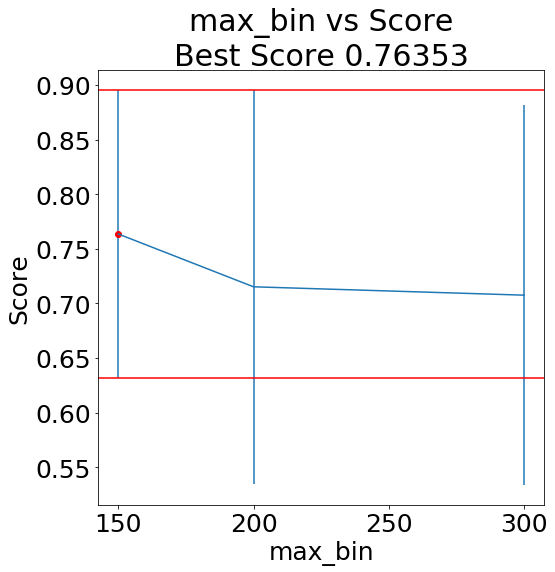

In [22]:
GridSearch_table_plot(clf, "max_bin", display_all_params=False, negative=False)

ignoring max_bin

## Tuning drop_rate

In [27]:
%%time

param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5],
    'num_leaves': [9],
    'feature_fraction': [0.5],
    'drop_rate': [0.2, 0.3, 0.4]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] drop_rate=0.2, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] drop_rate=0.2, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] drop_rate=0.2, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV]  drop_rate=0.2, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.519698227336043, total= 1.4min
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9 
[CV]  drop_rate=0.2, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.635

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.8min remaining:  2.4min


[CV]  drop_rate=0.4, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.5685707539069208, total= 3.0min
[CV]  drop_rate=0.4, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.5828534356097468, total= 2.3min
[CV]  drop_rate=0.4, feature_fraction=0.5, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=9, score=0.9522284713874102, total= 5.9min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  9.6min finished


CPU times: user 50.7 s, sys: 2.22 s, total: 52.9 s
Wall time: 10min 56s


In [28]:
roc_auc_score(clf.predict(X), Y.values)

0.5729818082646244

In [29]:
sum(clf.predict(test[features]))

496

best parameters: {'drop_rate': 0.2, 'feature_fraction': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 4000, 'num_leaves': 9}
best score:      0.70239 (+/-0.18285)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_drop_rate,param_feature_fraction,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,131.479100,59.724828,8.561122,9.017613,0.2,0.5,0.2,5,5,4000,9,"{'drop_rate': 0.2, 'feature_fraction': 0.5, 'l...",0.952229,0.635241,0.519698,0.702389,0.182852,1,1.0,0.684503,0.539517,0.741340,0.192239
2,216.476533,85.251239,7.243511,6.918567,0.4,0.5,0.2,5,5,4000,9,"{'drop_rate': 0.4, 'feature_fraction': 0.5, 'l...",0.952228,0.568571,0.582853,0.701218,0.177587,2,1.0,0.601058,0.648679,0.749912,0.177904
1,135.393960,55.594620,8.693743,8.906222,0.3,0.5,0.2,5,5,4000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.952228,0.544893,0.587559,0.694894,0.182795,3,1.0,0.567841,0.623044,0.730295,0.192037


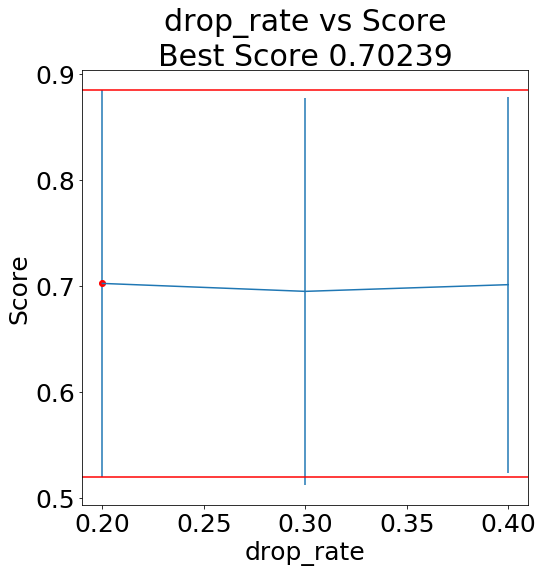

In [30]:
GridSearch_table_plot(clf, "drop_rate", display_all_params=False, negative=False)

Taking 0.3

### Increasing n-estimators and bringing down learning_rate

In [9]:
%%time

param_grid = {
    'n_estimators': [2000, 3000, 4000, 4500],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5],
    'num_leaves': [9],
    'feature_fraction': [0.5],
    'drop_rate': [0.3]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9 
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9 
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9 
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=3000, num_leaves=9 
[CV]  drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9, score=0.9713113229148778, total= 4.3min
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=3000, num_leaves=9 
[CV]  drop_rate=0.3, feature_fraction=0.5, learning_rate=0.05, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9, s

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 43.0min


[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.15, max_depth=5, min_data_in_leaf=5, n_estimators=3000, num_leaves=9 
[CV]  drop_rate=0.3, feature_fraction=0.5, learning_rate=0.1, max_depth=5, min_data_in_leaf=5, n_estimators=4500, num_leaves=9, score=0.9666197581747986, total= 6.6min
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.15, max_depth=5, min_data_in_leaf=5, n_estimators=3000, num_leaves=9 
[CV]  drop_rate=0.3, feature_fraction=0.5, learning_rate=0.15, max_depth=5, min_data_in_leaf=5, n_estimators=2000, num_leaves=9, score=0.6082015920265104, total= 2.4min
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.15, max_depth=5, min_data_in_leaf=5, n_estimators=3000, num_leaves=9 
[CV]  drop_rate=0.3, feature_fraction=0.5, learning_rate=0.1, max_depth=5, min_data_in_leaf=5, n_estimators=4500, num_leaves=9, score=0.9670955215906273, total= 7.0min
[CV] drop_rate=0.3, feature_fraction=0.5, learning_rate=0.15, max_depth=5, min_data_in_leaf=5, n_estimators=400

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 66.7min finished


CPU times: user 47.5 s, sys: 2.77 s, total: 50.3 s
Wall time: 1h 8min 31s


In [10]:
roc_auc_score( Y.values,clf.predict_proba((X))[:,1])

0.9998777640674238

In [11]:
sum(clf.predict(test[features]))

11

best parameters: {'drop_rate': 0.3, 'feature_fraction': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 2000, 'num_leaves': 9}
best score:      0.97129 (+/-0.00009)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_drop_rate,param_feature_fraction,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,254.342099,5.626559,12.454894,2.321947,0.3,0.5,0.05,5,5,2000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.971311,0.971386,0.971177,0.971291,0.000086,1,0.999996,0.999999,0.999989,0.999995,4.209071e-06
1,405.510742,14.828496,18.456440,0.929115,0.3,0.5,0.05,5,5,3000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.970226,0.969945,0.970773,0.970315,0.000343,2,1.000000,1.000000,0.999999,1.000000,3.335197e-07
4,169.289162,5.702980,11.360146,2.395803,0.3,0.5,0.1,5,5,2000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.969763,0.969755,0.970232,0.969917,0.000223,3,1.000000,1.000000,1.000000,1.000000,1.218082e-07
2,507.145255,19.532007,21.179213,1.923667,0.3,0.5,0.05,5,5,4000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.969516,0.968829,0.970134,0.969493,0.000533,4,1.000000,1.000000,1.000000,1.000000,1.239516e-07
3,506.177430,44.891471,32.224789,7.947524,0.3,0.5,0.05,5,5,4500,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.968135,0.968351,0.969758,0.968748,0.000720,5,1.000000,1.000000,1.000000,1.000000,1.218082e-07
5,264.172724,4.756002,22.299942,4.283611,0.3,0.5,0.1,5,5,3000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.968690,0.968439,0.968321,0.968483,0.000154,6,1.000000,1.000000,1.000000,1.000000,1.218082e-07
6,348.325463,12.118200,26.809844,3.610383,0.3,0.5,0.1,5,5,4000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.967174,0.967110,0.968123,0.967469,0.000463,7,1.000000,1.000000,1.000000,1.000000,1.218082e-07
7,373.142511,7.229404,34.068625,1.929182,0.3,0.5,0.1,5,5,4500,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.966388,0.966620,0.967096,0.966701,0.000294,8,1.000000,1.000000,1.000000,1.000000,1.218082e-07
9,226.330256,56.272949,9.668303,5.454810,0.3,0.5,0.15,5,5,3000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.963442,0.664238,0.577773,0.735151,0.165241,9,1.000000,0.674141,0.594220,0.756120,1.755082e-01
13,112.748074,42.249641,5.172790,4.011790,0.3,0.5,0.2,5,5,3000,9,"{'drop_rate': 0.3, 'feature_fraction': 0.5, 'l...",0.954301,0.623261,0.613748,0.730437,0.158344,10,1.000000,0.625534,0.647687,0.757740,1.715419e-01


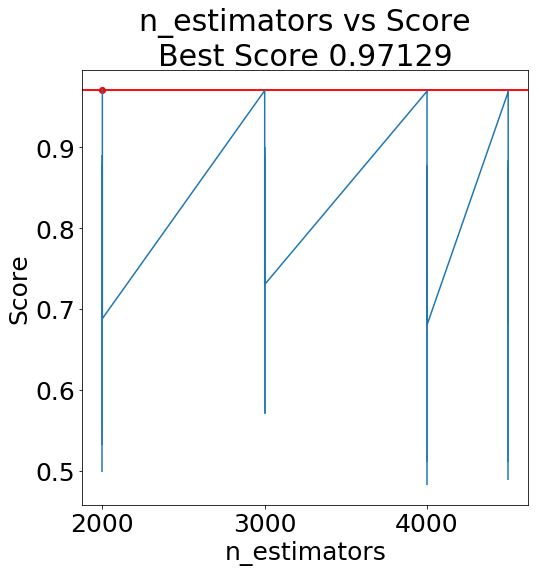

In [13]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

# Training the final Model

In [24]:
%%time


param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_data_in_leaf' : [5],
    'num_leaves': [30],
    'feature_fraction': [0.3],
    'drop_rate': [0.2]
    
}
lgbm = LGB.LGBMClassifier(objective='binary', nthreads=-1, seed=27, verbosity=2, is_imbalance=True, metric='auc')

clf = GridSearchCV(lgbm, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV] drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV] drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30 
[CV]  drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.957988834188817, total= 3.8min
[CV]  drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9657913065048562, total= 3.8min
[CV]  drop_rate=0.2, feature_fraction=0.3, learning_rate=0.2, max_depth=5, min_data_in_leaf=5, n_estimators=4000, num_leaves=30, score=0.9650720959668238, total= 3.9min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.1min finished


CPU times: user 1min 26s, sys: 5.33 s, total: 1min 32s
Wall time: 7min


In [25]:
roc_auc_score( Y.values,clf.predict_proba((X))[:,1])

0.9999997791502266

In [26]:
sum(clf.predict(test[features]))

92

## Plotting Feature Importances

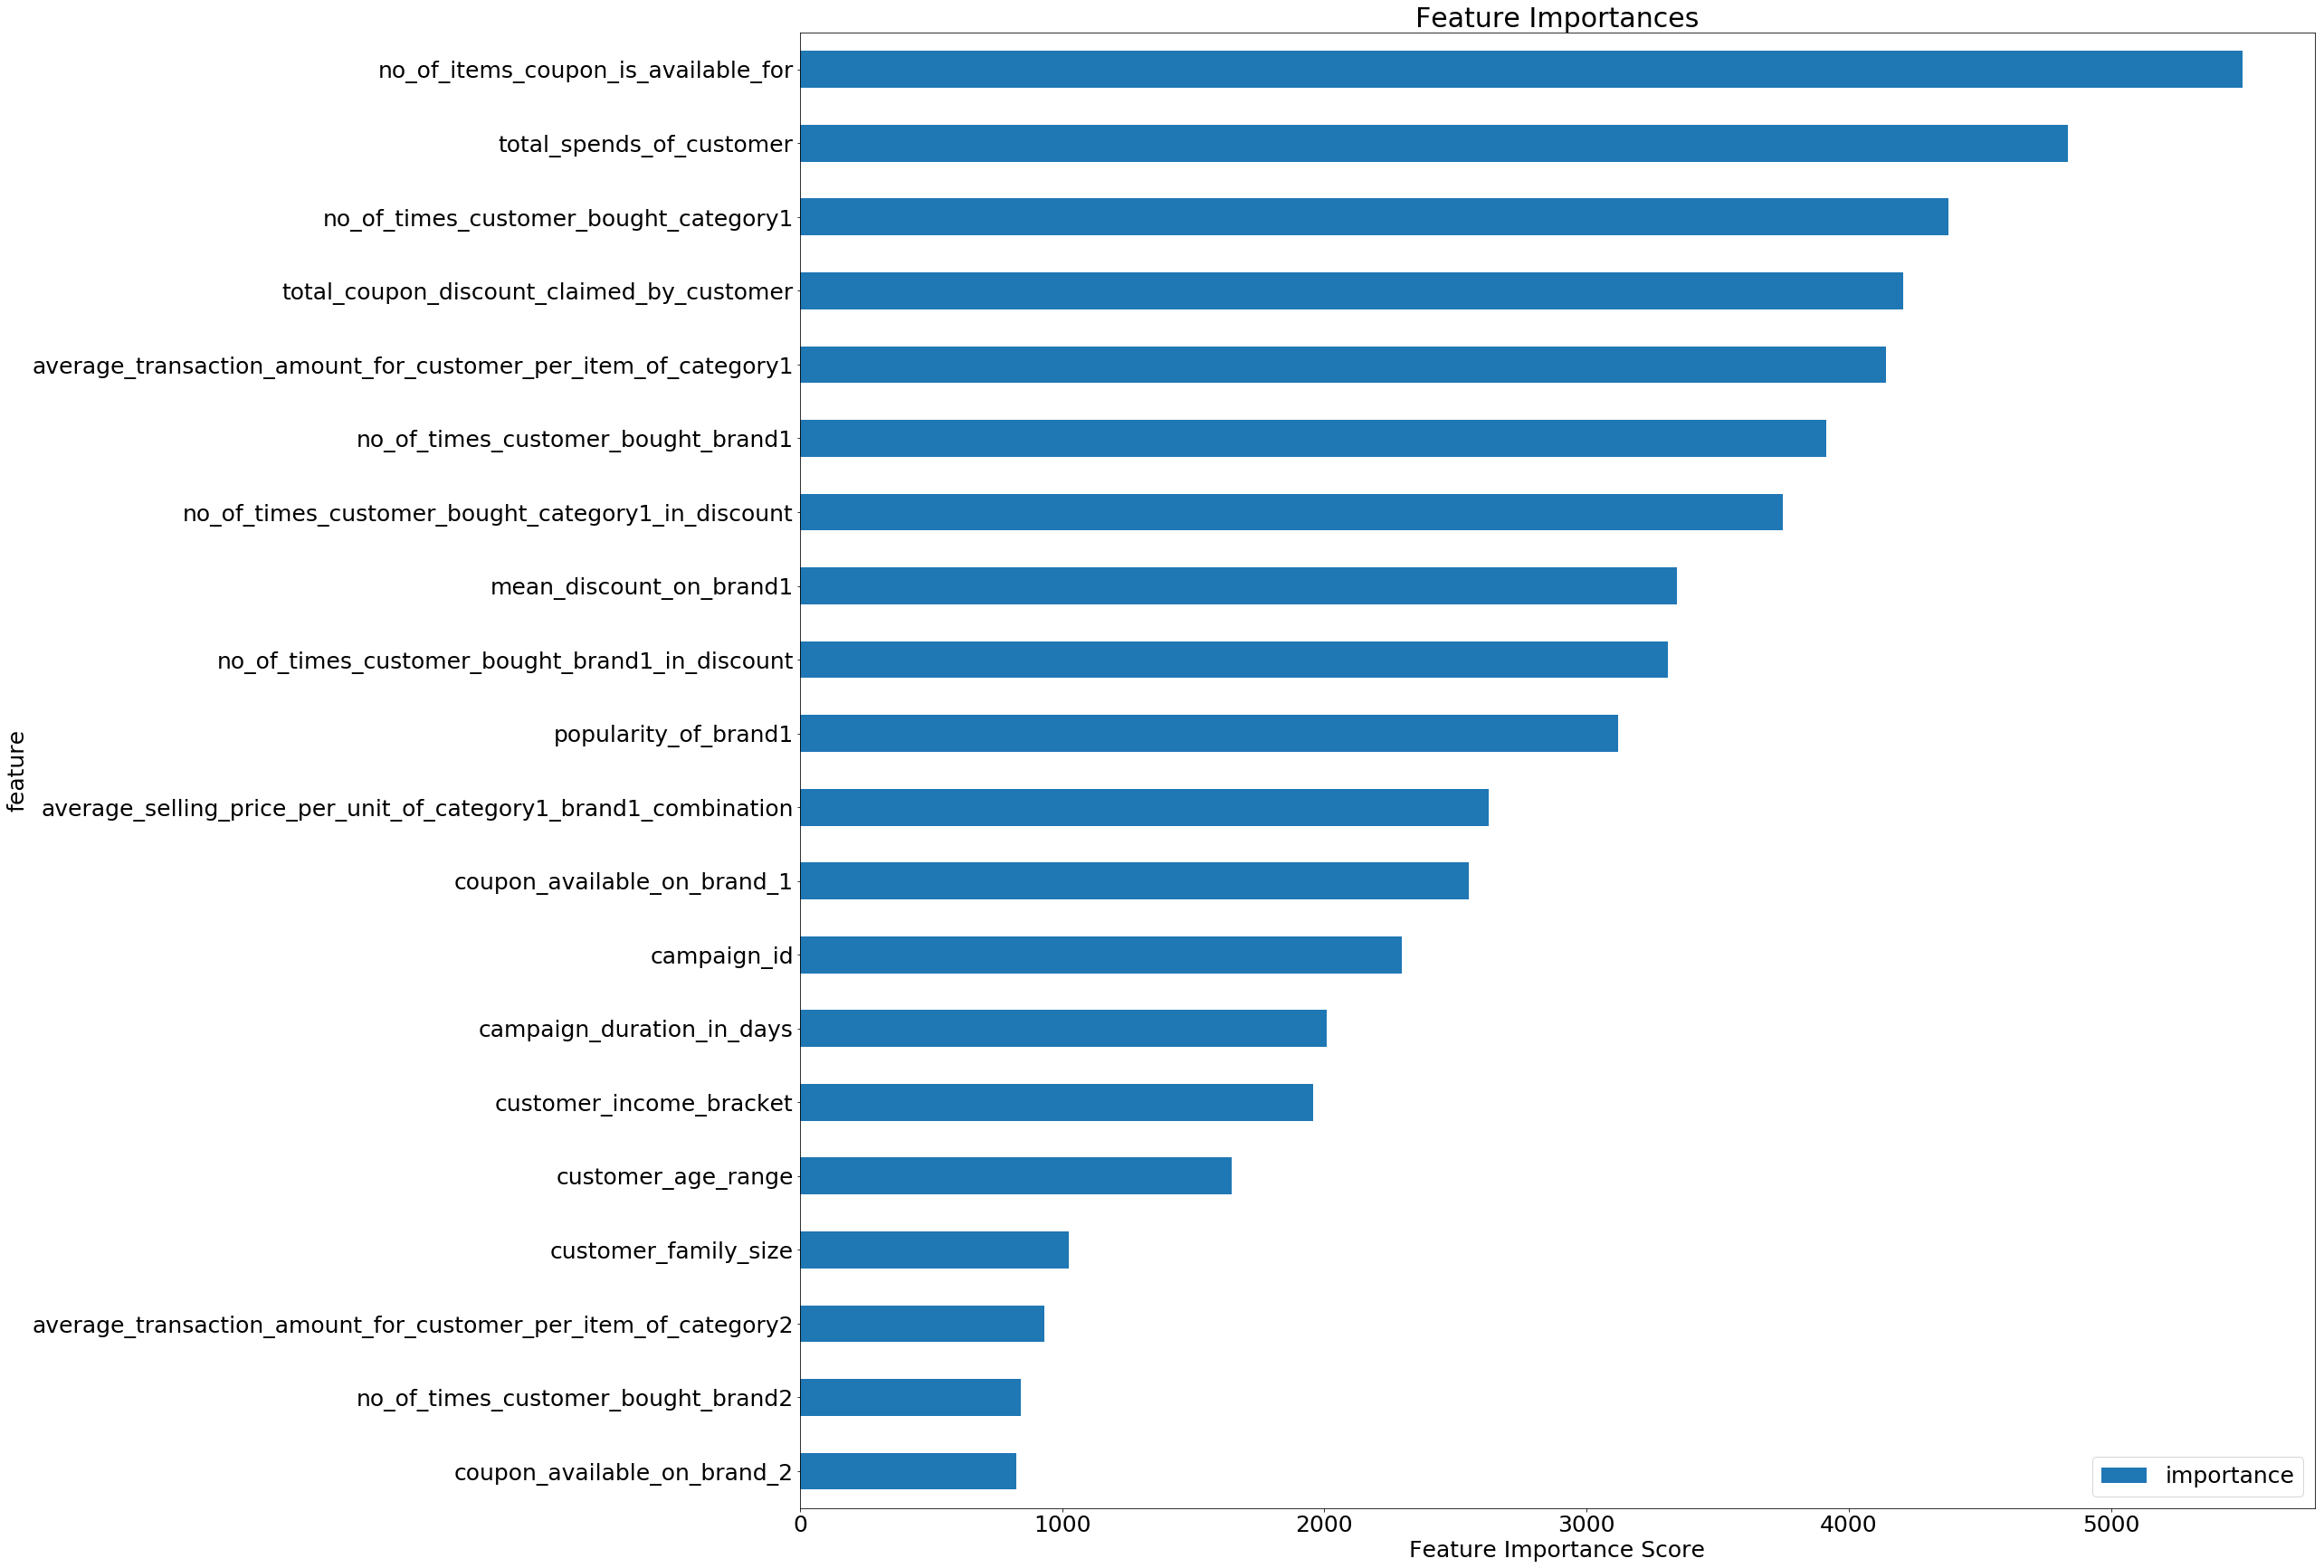

Top 20 features in descending order of importance


,importance
feature,
no_of_items_coupon_is_available_for,5502
total_spends_of_customer,4837
no_of_times_customer_bought_category1,4381
total_coupon_discount_claimed_by_customer,4208
average_transaction_amount_for_customer_per_item_of_category1,4143
no_of_times_customer_bought_brand1,3914
no_of_times_customer_bought_category1_in_discount,3750
mean_discount_on_brand1,3344
no_of_times_customer_bought_brand1_in_discount,3311


In [27]:
def plot_importance(clf, top_n, title="Feature Importances", figsize=(30,30) ):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = train[features].columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    print("Top {} features in descending order of importance".format(top_n))
    display(feat_imp.sort_values(by='importance', ascending=False))
    
plot_importance(clf.best_estimator_, 20)

## Saving submissions

In [28]:
c='final'
test['redemption_status'] =clf.predict_proba(test[features])[:,1]
submission = test.loc[:,['id', 'redemption_status']]
name = "../data/submissions/submission_after_modeling_lgb_"+str(c)+".csv"
submission.to_csv( name,index=False)
print("File saved!")
test['redemption_status']

File saved!


0        2.599883e-06
1        1.382858e-13
2        8.187779e-13
3        4.457943e-19
4        8.839125e-17
             ...     
50221    5.654780e-13
50222    6.369129e-09
50223    1.684187e-13
50224    2.174521e-09
50225    7.299851e-90
Name: redemption_status, Length: 50226, dtype: float64

In [29]:
clf.predict_proba(test[features])[:,1]

array([2.59988274e-06, 1.38285788e-13, 8.18777946e-13, ...,
       1.68418728e-13, 2.17452067e-09, 7.29985149e-90])

In [62]:
clf.predict_proba(test[features])

array([[9.99999584e-01, 4.15599085e-07],
       [1.00000000e+00, 4.10959787e-14],
       [1.00000000e+00, 9.71798548e-11],
       ...,
       [1.00000000e+00, 8.32453308e-11],
       [9.99999999e-01, 5.24984757e-10],
       [1.00000000e+00, 2.31476635e-18]])